# Lesson 4: Persistence and Streaming

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
#from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
import os
from langchain_groq import ChatGroq
model = ChatGroq(model_name="llama3-groq-70b-8192-tool-use-preview", api_key=os.environ.get("GROQ_API_KEY"))

In [4]:
tool = TavilySearchResults(max_results=2)

In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [6]:
#!pip install langgraph-checkpoint-sqlite
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)
#memory = SqliteSaver.from_conn_string(":memory:")  # in memory sqlite db

In [7]:
class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        
        graph.add_node("llm", self.call_llm)
        graph.add_node("action", self.take_action)
        
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        
        self.graph = graph.compile(checkpointer=checkpointer) # checkpointer=memory
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    def call_llm(self, state: AgentState):
        messages = state['messages']
        if self.system: # if system message defined, prepend it.
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}  # model response

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]  #last message in the state
        return len(result.tool_calls) > 0  # if there are tool calls

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

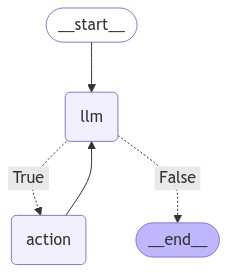

In [8]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
#model = ChatOpenAI(model="gpt-4o")
model = ChatGroq(model_name="llama3-groq-70b-8192-tool-use-preview")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [9]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
#user query
messages = [HumanMessage(content="What is the weather in sf?")]

In [11]:
thread = {"configurable": {"thread_id": "1"}}

In [12]:
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='The current weather in San Francisco, California, is partly cloudy with a temperature of 15.6°C (60.1°F). The wind is blowing from the northeast at 3.8 mph (6.1 kph). The humidity is at 27%, and the pressure is 1018.0 hPa (30.06 in).', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 1666, 'total_tokens': 1737, 'completion_time': 0.22550526, 'prompt_time': 0.104829502, 'queue_time': 0.0011165890000000012, 'total_time': 0.330334762}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-adc85999-279e-498c-bc2a-74e71fda3856-0', usage_metadata={'input_tokens': 1666, 'output_tokens': 71, 'total_tokens': 1737})]


In [13]:
messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='The current weather in Los Angeles, California, is clear with a temperature of 16.1°C (61.0°F). The wind is blowing from the northeast at 3.8 mph (6.1 kph). The humidity is at 67%, and the pressure is 1016.0 hPa (30.0 in).', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 1751, 'total_tokens': 1821, 'completion_time': 0.222943634, 'prompt_time': 0.124992318, 'queue_time': 0.0013619110000000073, 'total_time': 0.347935952}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-53b2bc6e-3334-4dc5-9ceb-24e5ee893c6b-0', usage_metadata={'input_tokens': 1751, 'output_tokens': 70, 'total_tokens': 1821})]}


In [14]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='Los Angeles is warmer than San Francisco.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 1835, 'total_tokens': 1844, 'completion_time': 0.026054533, 'prompt_time': 0.138416058, 'queue_time': 0.001044619999999996, 'total_time': 0.164470591}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-2677b0ce-9b09-427c-a995-5736eed5c054-0', usage_metadata={'input_tokens': 1835, 'output_tokens': 9, 'total_tokens': 1844})]}


In [15]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content="I'm sorry but I do not have the capability to perform this task for you, I am happy to help you with any other queries you may have.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 337, 'total_tokens': 369, 'completion_time': 0.100487472, 'prompt_time': 0.028098478, 'queue_time': 0.0046581890000000035, 'total_time': 0.12858595}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-7502713b-4c96-4ad1-91c4-6edb4f051e74-0', usage_metadata={'input_tokens': 337, 'output_tokens': 32, 'total_tokens': 369})]}


## Streaming tokens

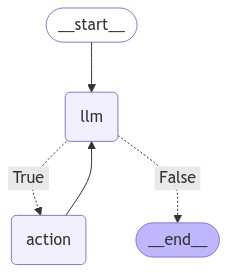

In [16]:
#from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver  # this is causing dependency problem

#memory = AsyncSqliteSaver.from_conn_string(":memory:")

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [17]:
messages = [HumanMessage(content="What is the weather in SF?")]
thread = {"configurable": {"thread_id": "4"}}
async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_98cf', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_z3r3', 'type': 'tool_call'}
Back to the model!
The| current| weather| in| San| Francisco| is| partly| cloudy| with| a| temperature| of| |60|.|1|°F| (|15|.|6|°C|).| The| wind| is| blowing| from| the| N|NE| at| |3|.|8| mph| (|6|.|1| k|ph|).| The| humidity| is| at| |27|%,| and| the| visibility| is| |9| miles| (|16| km|).| There| are| no| precipitation| reports|,| and| the| dew| point| is| at| |45|.|5|°F| (|7|.|5|°C|).|